## Modeling

### Part A

First we read in data, look at the summary and clean it.

In [1]:
import warnings; 
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
%matplotlib inline

In [2]:
train_data = pd.read_csv("http://s3.amazonaws.com/istreet-assets/W4GaPMGXVPubSkvjZyAn5w/Product%20Data%20Set.csv",sep=",",header=0)
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_year,12357.0,2011.615522,4.884473,1993.0,2008.0,2013.0,2016.0,2018.0


In [3]:
train_data.describe(exclude=[np.number]).transpose()

,count,unique,top,freq
id,12357,11655,a4c8af2e-ac1b-4c1b-b397-43a7f3dc8b66,5
city_name,12357,3,Strark,6888
signup_os,6953,5,ios web,3227
signup_channel,11143,5,Referral,5759
signup_timestamp,11194,10575,2017-07-27T21:18:17Z,5
bgc_date,7803,7335,2017-07-27T21:18:37Z,5
vehicle_added_date,11121,10509,2017-07-31T23:24:52Z,5
vehicle_make,11727,49,Toyota,2816
vehicle_model,12357,485,Civic,749
first_completed_trip_timestamp,6790,6266,2017-07-30T00:23:57Z,5


We see that the counts of each variable are different so there must be missing values.

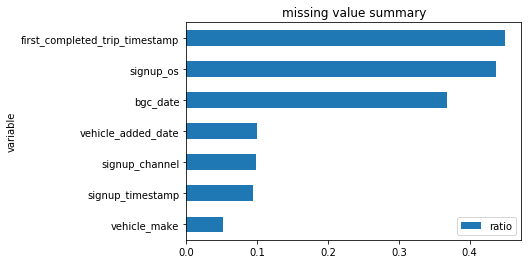

In [4]:
missing_values=train_data.isna().sum()
missing_values=pd.DataFrame({'variable':missing_values.index,'count':missing_values.values})
missing_values['ratio']=missing_values['count']/train_data.shape[0]

missing_values[missing_values['count']>0].sort_values(by=['ratio']).plot(kind='barh',
              x='variable',y='ratio',title='missing value summary',sort_columns=True)

Missing first_completed_trip_timestamp will be seen as not completing any trip.

From the missing value ratio of each variable, we can see signup_os have very high ratio of missing values so we would just treat the missing values as a new level of the categorial variable. For other variables, we will treat them differently later.

It's weird to have vehicles missing their make information but not their models. So we can just treat those vehicles with "Other" make and model. 

The drivers missing signup timestamp will cause ambiguity s if we want to look at whether they completed the first trips within 30 days of signing up, so we should delete them, and encode the remaing timestamp variables. 

We would also extract the day of week information from the signup timestamp to help understand data better.

In [5]:
train_data=train_data.drop(train_data[train_data['signup_timestamp'].isna()].index)
train_data.loc[train_data['signup_os'].isna(),'signup_os']='Unknown'
train_data.loc[train_data['signup_channel'].isna(),'signup_channel']='Unknown'
train_data.loc[train_data['vehicle_make'].isna(),'vehicle_model']="Other"
train_data['vehicle_make']=train_data['vehicle_make'].replace(to_replace=np.NaN,value="Other")

date_format = "%Y-%m-%dT%H:%M:%SZ" 
train_data['first_trip']=pd.to_datetime(train_data['first_completed_trip_timestamp'],format=date_format)
train_data['signup']=pd.to_datetime(train_data['signup_timestamp'],format=date_format)
train_data['signup_weekday']=train_data['signup'].apply(lambda x: datetime.datetime.weekday(x))
print("Time range of this cohort: {} to {}".format(train_data['signup'].min(),train_data['signup'].max()))

Time range of this cohort: 2017-07-01 00:02:08 to 2017-07-31 23:59:42


Add a 'convert' variable to indicate whether the driver completed their first trip within 30 days of signing up. Those missing first_completed_trip_timestamp values are seen as not converted. Then we can answer the question in part A: what fraction of signup drivers took a first trip within 30 days of signing up.

In [6]:
train_data['convert']=(train_data['first_trip']-train_data['signup'])<=datetime.timedelta(days=30)
train_data.loc[train_data['first_trip'].isna(),'convert']=False

print("{:.2%} fraction of signup drivers took a first trip within 30 days of signing up.".format(train_data['convert'].mean()))

54.68% fraction of signup drivers took a first trip within 30 days of signing up.


We also know that each driver must pass the background check before they can start their trips. So for our next predictive modeling, we can delete the observations missing background check since those shouldn't be giving information for conversion.

In [7]:
train_data=train_data.drop(train_data[train_data['bgc_date'].isna()].index)

Now we are done with data cleaning, we need to dig deeper into some categorical variables and consider further feature encoding/engineering.

We first explore the difference between signup channel and platform in each city. 

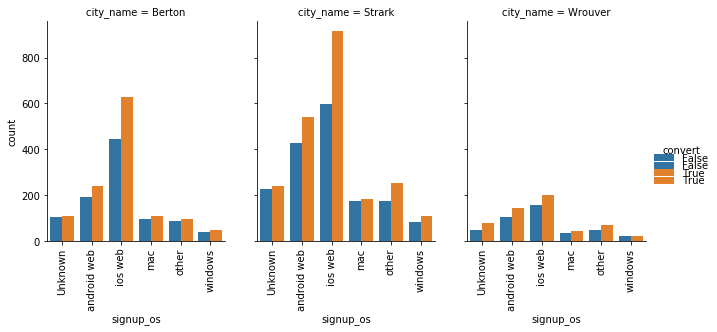

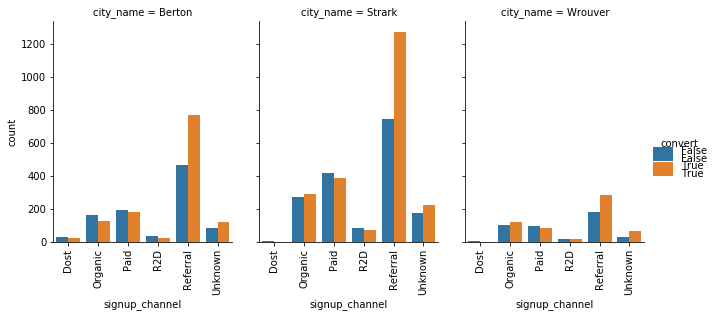

In [8]:
res1=train_data.groupby(['city_name','convert','signup_os'],as_index=False).size()

res1=pd.DataFrame(res1)
res1.reset_index(inplace=True)
res1.rename({0:'count'},axis='columns',inplace=True)


g = sb.catplot(x="signup_os", y="count",
                hue="convert", col="city_name",
                 data=res1, kind="bar",
                 height=4, aspect=.7);
g.add_legend()
g.set_xticklabels(rotation=90)

res2=train_data.groupby(['city_name','convert','signup_channel'],as_index=False).size()

res2=pd.DataFrame(res2)
res2.reset_index(inplace=True)
res2.rename({0:'count'},axis='columns',inplace=True)

g = sb.catplot(x="signup_channel", y="count",
                hue="convert", col="city_name",
                 data=res2, kind="bar",
                 height=4, aspect=.7);
g.add_legend()
g.set_xticklabels(rotation=90)

Drivers sign up through ios web or android web are more likely to start the first trip in 30 days.

Referred drivers are obviously more likely to start their first trip in 30 days.

We then explore the conversion rate with respect to each level of some categorical variables.

<Figure size 432x288 with 0 Axes>

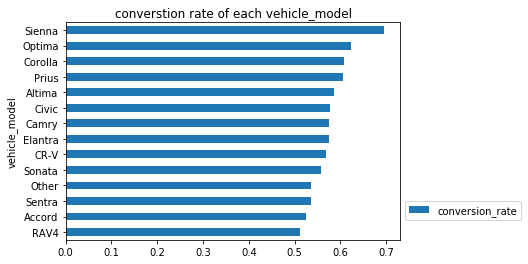

<Figure size 432x288 with 0 Axes>

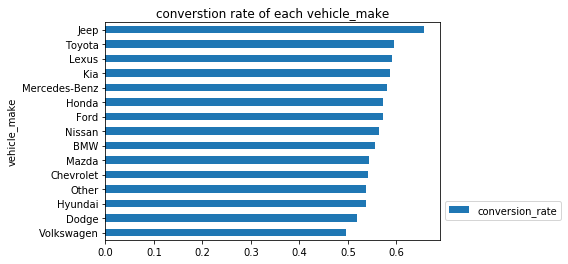

<Figure size 432x288 with 0 Axes>

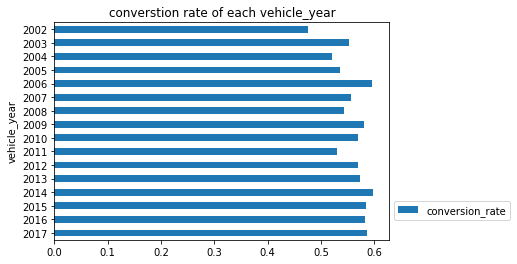

<Figure size 432x288 with 0 Axes>

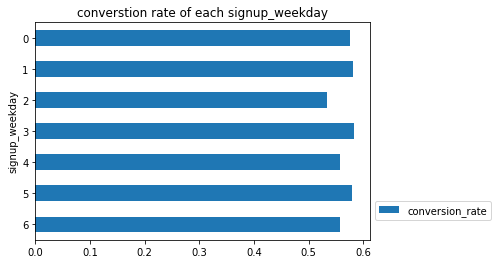

In [9]:
# function to plot the converstion rate against each level of a categorical variable
# if there are too many levels of the variable, only plot the levels with a frequency higher than the cutoff
def conversion_rate_per_category(data,variable,cutoff,sort=True):
    count=data.groupby([variable]).size()
    keys=count[count>cutoff].index.tolist()
    res=data[data[variable].isin(keys)].groupby([variable]).apply(lambda x: x['convert'].sum()/len(x))
    res=pd.DataFrame(res)
    res.reset_index(inplace=True)
    res.rename({0:'conversion_rate'},axis='columns',inplace=True)
    plt.figure()
    if sort:
        res.sort_values(by=['conversion_rate']).plot(kind='barh',
                        x=variable,y="conversion_rate",title='converstion rate of each '+variable)
    else:
        res.sort_values(by=variable,ascending=False).plot(kind='barh',
                        x=variable,y="conversion_rate",title='converstion rate of each '+variable)
    plt.legend(bbox_to_anchor=(1, 0.2))
conversion_rate_per_category(train_data,'vehicle_model',100)
conversion_rate_per_category(train_data,'vehicle_make',100)
conversion_rate_per_category(train_data,'vehicle_year',100,False)
conversion_rate_per_category(train_data,'signup_weekday',0,False)

With respect to vehicle model, Versa, Sienna, Optima, Focus and Corolla owners tend to have higher converstion rate.

With respect to vehicle make, Acura Kia and Toyota owners, tend to higher conversion rate, but the advantage is not as conspicuous as the above model owners. Subaru, Scion, Dodge, Volkswage and Chrysler drivers tend to have lower converstion rate. 

Newer cars tend to higher conversion rate but the relationship is not monotone.

The difference between each week day is not significant. Monday has the comparably highest converstion rate.

Now I add new variables of the time difference from the signup time to background check/vehicle adding time  as the response time. We first ignore drivers with missing values in background check/vehicle and plot the repsonse time to see whether there is any difference.

[]

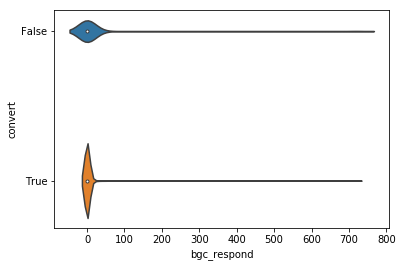

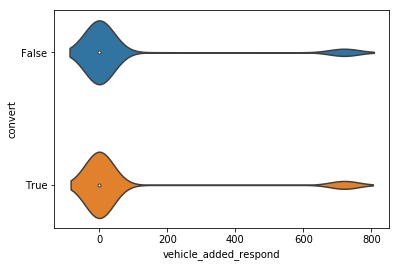

In [10]:
train_data['bgc_date'] = pd.to_datetime(train_data['bgc_date'],  format=date_format)
train_data['vehicle_added_date'] = pd.to_datetime(train_data['vehicle_added_date'], format=date_format)

train_data['bgc_respond']= train_data['bgc_date']-train_data['signup']
#train_data.loc[(train_data['bgc_respond'].isna())&(train_data['convert']),'bgc_respond']=train_data['bgc_respond'].median()
#train_data.loc[train_data['bgc_respond'].isna(),'bgc_respond']=1.5*train_data['bgc_respond'].max()

train_data['vehicle_added_respond']= train_data['vehicle_added_date']-train_data['signup']
train_data.loc[train_data['vehicle_added_respond'].isna(),'vehicle_added_respond']=1.5*train_data['vehicle_added_respond'].max()
train_data['bgc_respond']=train_data['bgc_respond'].astype('timedelta64[h]')
train_data['vehicle_added_respond']=train_data['vehicle_added_respond'].astype('timedelta64[h]')

# Response time longer than 30 days or with negative values will be clipped to 30 and 0 respectively
train_data['bgc_respond']=train_data['bgc_respond'].apply(np.clip,a_min=0,a_max=30*24)
train_data['vehicle_added_respond']=train_data['vehicle_added_respond'].apply(np.clip,a_min=0,a_max=30*24)
plt.figure()
ax1=sb.violinplot(y='convert',x='bgc_respond',data=train_data,orient='h',width=0.5)

plt.plot()

plt.figure()

ax2=sb.violinplot(y='convert',x='vehicle_added_respond',data=train_data,orient='h',width=0.5)
plt.plot()

We can see that there for either converted driver or not converted ones, the response time are all highly focused at 0. This means that most drivers finish their background check and add their vehicles right after signup. 

In [11]:
#train_data.loc[(train_data['bgc_respond'].isna())&(train_data['convert']),'bgc_respond']=train_data['bgc_respond'].median()
#train_data.loc[train_data['bgc_respond'].isna(),'bgc_respond']=train_data['bgc_respond'].median()

#train_data.loc[train_data['vehicle_added_respond'].isna(),'vehicle_added_respond']=train_data['vehicle_added_respond'].median()

Now we need to encode the categorical values. For city_name, we directly do one hot encoding. 

For signup_channel and signup_os, we only select the level with different conversion rate than others. 

Signup_weekday is rather indifferent to conversion rate so it's not going to be used in the predictive model.

For vehicle make and model, we combine levels with least frequency less than certain quantile as 'Other' and do target encoding to remaining levels.

For vehicle year, we treat it as a numeric variable and use MinMaxScaler from sklearn to normalize it as well as response time of background check/vehicle adding.

Then we are done with the first part, data cleaning, exploratory analyis and visualization.

In [12]:
def encode_categorical_variable_fewer_value(data,variable,values):
    for value in values:
        var_name=variable+'_'+str(value)
        data[var_name]=data[variable]==value
    new_data=data.drop(variable,axis=1)
    return new_data
train_data=encode_categorical_variable_fewer_value(train_data,'city_name',train_data['city_name'].unique())
train_data=encode_categorical_variable_fewer_value(train_data,'signup_channel',['Referral'])
train_data=encode_categorical_variable_fewer_value(train_data,'signup_os',['andorid web','ios web'])


def encode_categorical_variable(data,variable,cutoff):
    count=data.groupby([variable]).size()
    count=count.sort_values()
    count_cumportion=count.agg(np.cumsum)/count.agg(np.sum)
    not_selected=count_cumportion[count_cumportion<cutoff].index.tolist()
    data[variable]=data[variable].replace(to_replace=not_selected,value='Other')
    res=data.groupby([variable]).apply(lambda x: x['convert'].sum()/len(x))
    res=pd.DataFrame(res)
    res.reset_index(inplace=True)
    res.rename({0:variable+'_conv_rate'},axis='columns',inplace=True)
    new_data=data.merge(res,how='left',on=variable)
    new_data=new_data.drop(variable,axis=1)
    return new_data
train_data=encode_categorical_variable(train_data,'vehicle_model',0.2)
train_data=encode_categorical_variable(train_data,'vehicle_make',0.05)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data[['vehicle_year','bgc_respond','vehicle_added_respond']]=scaler.fit_transform(train_data[['vehicle_year','bgc_respond','vehicle_added_respond']])
train_data_cleaned=train_data.drop(['id','signup_timestamp','first_completed_trip_timestamp',
                            'bgc_date','vehicle_added_date','first_trip', 'signup','signup_weekday'],axis=1)


### Part B

We first start with the logistics model and use all the variables selected above. The first logistic regression model we are going to build will be called the full model.

In [13]:
train_y=train_data_cleaned.pop('convert').astype(int)
train_X=train_data_cleaned
full_variables=np.array(train_X.columns.to_list())

import statsmodels.api as sm
logit_model=sm.Logit(train_y,train_X.astype('float64'))
result=logit_model.fit(method='bfgs',maxiter=200)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.658480
         Iterations: 77
         Function evaluations: 78
         Gradient evaluations: 78
                                     Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.037     
Dependent Variable:          convert                 AIC:                     9362.5187 
Date:                        2019-03-20 15:26        BIC:                     9431.1887 
No. Observations:            7094                    Log-Likelihood:          -4671.3   
Df Model:                    9                       LL-Null:                 -4851.5   
Df Residuals:                7084                    LLR p-value:             3.6938e-72
Converged:                   1.0000                  Scale:                   1.0000    
----------------------------------------------------------------------------------------
                         Coef.    Std.Err.      z    P>|z|      

From the summary table, we can see these variables are having desired low p-value: 'vehicle_year', 'bgc_respond', 'city_name_Strark', 'city_name_Berton', 'city_name_Wrouver','signup_channel_Referral',  'signup_os_ios web', 'vehicle_model_conv_rate'. We know compare the full model with the reduced model, which is built with the above significant variables, by cross validation score.

In [14]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
selected_variables1=['vehicle_year', 'bgc_respond', 
       'city_name_Strark', 'city_name_Berton', 'city_name_Wrouver',
       'signup_channel_Referral',  'signup_os_ios web',
        'vehicle_model_conv_rate']

from sklearn.cross_validation import cross_val_score, KFold
K=10
rng=2010
score_logit_full=cross_val_score(logreg, train_X, y=train_y, 
                cv=KFold(train_y.size, K,random_state=rng), n_jobs=1).mean()
score_logit_selected1=cross_val_score(logreg, train_X[selected_variables1], y=train_y, 
                cv=KFold(train_y.size, K,random_state=rng), n_jobs=1).mean()
print("Cross validation scores of the full model and the reduced model are respectively:{:.4} and {:.4}"
      .format(score_logit_full,score_logit_selected1))

/Users/zeren/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Cross validation scores of the full model and the reduced model are respectively:0.5991 and 0.5973


Both models have relatively low cross validation scores. It may suggest we should try another model to fit the data. Next we will try random forest models and select the prameters with grid search. The reduced model doesn't have 

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid={
        'max_depth':[10,30,50],
        'n_estimators':[50,100,300]
        }
from sklearn.model_selection import GridSearchCV
rf_search = GridSearchCV(rf,param_grid=param_grid,
                              cv=KFold(train_y.size, K,random_state=rng),n_jobs=-1,verbose=0)
rf_search.fit(train_X,train_y)
score_rf_full=rf_search.best_score_
rf_selected=rf_search.best_estimator_
selected_variables_rf=full_variables[rf_selected.feature_importances_>0.1]
print("Variables with feature importance higher than 0.1 in this random forest model are:")
print(selected_variables_rf)

Variables with feature importance higher than 0.1 in this random forest model are:
['vehicle_year' 'bgc_respond' 'vehicle_model_conv_rate'
 'vehicle_make_conv_rate']


Now we try to build a reduced random forest model based on the variables selected above.

In [16]:
rf_search_selected = GridSearchCV(rf,param_grid=param_grid,
                              cv=KFold(train_y.size, K,random_state=rng),n_jobs=-1,verbose=0)
rf_search_selected.fit(train_X[selected_variables_rf],train_y)
score_rf_selected=rf_search_selected.best_score_

print("Cross validation scores of the full model and the reduced model are respectively:{:.4} and {:.4}"
      .format(score_rf_full,score_rf_selected))

Cross validation scores of the full model and the reduced model are respectively:0.5929 and 0.5727


So we can see the model with the highest cross validation score is the full logistic regression model. It gives us a direct understanding of the relationship between predictors and the probability of driver conversion. Let's build this model on a random selected subset of our data and test it on the remaining.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(train_X,train_y, test_size=0.2, random_state=rng)
logit_model_full=sm.Logit(y_train_logit,X_train_logit.astype('float64'))
result_full=logit_model_full.fit(method='bfgs',maxiter=200)
y_predicted_logit = result_full.predict(X_test_logit.astype('float64'))
auc = roc_auc_score(y_true=y_test_logit, y_score=y_predicted_logit)

print('AUC for 20%% holdout: %s' %auc)
print('Confucion matrix for the test set:')
print(confusion_matrix(y_test_logit,y_predicted_logit>0.5))
print('Accuracy score for the test set:{:2%}'.format(accuracy_score(y_test_logit,y_predicted_logit>0.5)))

Optimization terminated successfully.
         Current function value: 0.659896
         Iterations: 78
         Function evaluations: 79
         Gradient evaluations: 79
AUC for 20% holdout: 0.629280950354
Confucion matrix for the test set:
[[210 399]
 [135 675]]
Accuracy score for the test set:62.367865%


Overall the prediction performance is not very ideal. False positive is particularly high. Overfitting is less likely here since we tried models with fewer predictors but it didn't help. More variables may need to be considered and included, such as salary, part time or full time driver, etc. 

### Part C

There are some insights we can get from the above analysis:
1. Referral should be encouraged more. Referred drivers are more likely to complete their first trip within the first 30 days.
2. Drivers finish backgroud check sooner are more likely to complete their first trip within the first 30 days. Uber can notify newly signup drivers to finish background check and accelerate the check process.
3. iOS users may have higher conversion rate. More ads and marketing events can be launched on iOS platform.
4. Newer vehicle owners are more likely to convert. Ads and marketing events can be targeted as this group.